In [1]:
import os, sys, copy, random
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import time, GPy
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d

from kernels.nn import ImplicitDenseNetKernel
from model.ick import ICK
from model.cmick import CMICK
from benchmarks.cmgp_modified import CMGP
from benchmarks.cevae_modified import *
from benchmarks.x_learner import X_Learner_RF, X_Learner_BART
from ganite import Ganite
from utils.train import CMICKEnsembleTrainer
from utils.losses import *
from utils.helpers import *

# To make this notebook's output stable across runs
random.seed(2020)
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. Load and preprocess data

In [2]:
def load_and_preprocess_data(N_train, N_test):
    train_dir = '../../data/ACIC_challenge/high_dimensional_datasets/high1601.csv'
    train_df = pd.read_csv(train_dir)
    test_dir = '../../data/ACIC_challenge/TestDatasets_highD/highDim_testdataset1.csv'
    test_df = pd.read_csv(test_dir)
    test_eval_dir = '../../data/ACIC_challenge/TestDatasets_highD_cf/highDim_testdataset1_cf.csv'
    test_eval_df = pd.read_csv(test_eval_dir)
    for c in train_df.columns:
        if c != 'Y' and c != 'A':
            scaler = StandardScaler()
            train_df[c] = scaler.fit_transform(train_df[c].to_numpy().reshape(-1,1)).reshape(-1)
    for c in test_df.columns:
        if c != 'Y' and c != 'A':
            scaler = StandardScaler()
            test_df[c] = scaler.fit_transform(test_df[c].to_numpy().reshape(-1,1)).reshape(-1)

    # Training data
    X_train = train_df.to_numpy()[:N_train, 2:]
    T_train = train_df.to_numpy()[:N_train, 1][:,None]
    Y_train = train_df.to_numpy()[:N_train, 0][:,None]

    # Test data
    X_test = test_df.to_numpy()[:N_test, 2:]
    T_test = test_df.to_numpy()[:N_test, 1][:,None]
    Y_test = test_df.to_numpy()[:N_test, 0][:,None]
    mu0_test = test_eval_df.to_numpy()[:N_test, -1][:,None]
    mu1_test = test_eval_df.to_numpy()[:N_test, -2][:,None]
    mu_test = mu1_test - mu0_test
    data = {'X_train': X_train, 'T_train': T_train, 'Y_train': Y_train, 'X_test': X_test,
            'mu0_test': mu0_test, 'mu1_test': mu1_test ,'mu_test': mu_test}

    # Initialize dataloaders
    data_train = [X_train, T_train]
    data_test = [X_test, T_test]
    data_generators = create_generators_from_data(data_train, Y_train, data_test, Y_test, 
                                                  train_batch_size=256, test_batch_size=1000)
    return data_generators, data

# 2. Define CMNN model

In [3]:
def build_cmnn_ensemble(input_dim, load_weights=False):
    alpha11, alpha12, alpha13 = 1.0, 1.0, 1.0
    alpha21, alpha22, alpha23 = 1.0, 1.0, 1.0
    num_estimators = 10

    ensemble, ensemble_weights = [], {}
    for i in range(num_estimators):
        f11 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 1, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'softplus'
                }
            }
        )
        f12 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 1, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'softplus'
                }
            }
        )
        f13 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 1, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'softplus'
                }
            }
        )
        f21 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 1, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'softplus'
                }
            }
        )
        f22 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 1, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'softplus'
                }
            }
        )
        f23 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 1, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'softplus'
                }
            }
        )
        if load_weights:
            for f in ['f11', 'f12', 'f13', 'f21', 'f22', 'f23']:
                eval(f).kernels[0].load_state_dict(torch.load('./checkpoints/cmick_acic.pt')['model_'+str(i+1)][f])
        else:
            model_weights = {
                'f11': f11.kernels[0].state_dict(), 'f12': f12.kernels[0].state_dict(), 'f13': f13.kernels[0].state_dict(), 
                'f21': f21.kernels[0].state_dict(), 'f22': f22.kernels[0].state_dict(), 'f23': f23.kernels[0].state_dict()
            }
            ensemble_weights['model_'+str(i+1)] = model_weights
        # Set output_binary=True for binary Y0 and Y1
        baselearner = CMICK(
            control_components=[f11,f21], treatment_components=[f12,f22], shared_components=[f13,f23],
            control_coeffs=[alpha11,alpha21], treatment_coeffs=[alpha12,alpha22], shared_coeffs=[alpha13,alpha23], 
            coeff_trainable=True, output_binary=True
        )
        ensemble.append(baselearner)
    if not load_weights:
        if not os.path.exists('./checkpoints'):
            os.makedirs('./checkpoints')
        torch.save(ensemble_weights, './checkpoints/cmick_acic.pt')

    return ensemble

# 3. Training and evaluation of ICK-CMGP model

In [4]:
def fit_and_evaluate_cmnn(ensemble, data_generators, mu_test, lr, treatment_index=1):
    # The index of "T_train" in "data_train" is 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optim = 'sgd'
    optim_params = {
        'lr': lr, 
        'momentum': 0.99,
        'weight_decay': 1e-4
    }
    epochs, patience = 1000, 10
    trainer = CMICKEnsembleTrainer(
        model=ensemble,
        data_generators=data_generators,
        optim=optim,
        optim_params=optim_params, 
        model_save_dir=None,
        device=device,
        epochs=epochs,
        patience=patience, 
        treatment_index=treatment_index
    )
    train_start = time.time()
    trainer.train()
    train_time = time.time() - train_start
    
    mean_test_pred, std_test_pred, y_test_true = trainer.predict()
    mu_test_pred = mean_test_pred[:,1] - mean_test_pred[:,0]
    pehe_test = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
    print('PEHE (CMNN):             %.4f' % (pehe_test))
    
    return pehe_test, train_time

# 4. Benchmark 1: original CMGP

In [5]:
def fit_and_evaluate_original_cmgp(data):
    X_train, T_train, Y_train = data['X_train'], data['T_train'], data['Y_train']
    X_test, mu_test = data['X_test'], data['mu_test']
#     K0 = GPy.kern.MLP(X_train.shape[1], weight_variance=0.1, bias_variance=0.1, ARD=False)
#     K1 = GPy.kern.MLP(X_train.shape[1], weight_variance=0.2, bias_variance=0.2, ARD=False)
    train_start = time.time()
    cmgp_model = CMGP(X_train, T_train, Y_train)
    train_time = time.time() - train_start
    
    mu0_test_pred, mu1_test_pred = cmgp_model.predict(X_test, return_var=False)
    mu_test_pred = mu1_test_pred - mu0_test_pred
    pehe_test = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
    print('PEHE (CMGP):             %.4f' % (pehe_test))
    
    return pehe_test, train_time

# 5. Benchmark 2: CEVAE

In [6]:
def fit_and_evaluate_cevae(data):
    lr = 1e-4
    weight_decay = 1e-4
    batch_size = int(data['X_train'].shape[0]/8)
    train_iters = 20000
    eval_iters = 200
    latent_dim = 20
    n_h = 64
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train, T_train, Y_train, X_test = torch.tensor(data['X_train']).float().to(device), torch.tensor(data['T_train']).float().to(device), \
                                        torch.tensor(data['Y_train']).float().to(device), torch.tensor(data['X_test']).float().to(device)

    # init networks (overwritten per replication)
    p_x_z_dist = p_x_z(dim_in=latent_dim, nh=3, dim_h=n_h).to(device)
    p_t_z_dist = p_t_z(dim_in=latent_dim, nh=1, dim_h=n_h, dim_out=1).to(device)
    p_y_zt_dist = p_y_zt(dim_in=latent_dim, nh=3, dim_h=n_h, dim_out=1, output_binary=True).to(device)
    q_t_x_dist = q_t_x(dim_in=X_train.shape[1], nh=1, dim_h=n_h, dim_out=1).to(device)

    # t is not feed into network, therefore not increasing input size (y is fed).
    q_y_xt_dist = q_y_xt(dim_in=X_train.shape[1], nh=3, dim_h=n_h, dim_out=1, output_binary=True).to(device)
    q_z_tyx_dist = q_z_tyx(dim_in=X_train.shape[1]+1, nh=3, dim_h=n_h, dim_out=latent_dim).to(device)
    p_z_dist = normal.Normal(torch.zeros(latent_dim).to(device), torch.ones(latent_dim).to(device))

    # Create optimizer
    params = list(p_x_z_dist.parameters()) + \
             list(p_t_z_dist.parameters()) + \
             list(p_y_zt_dist.parameters()) + \
             list(q_t_x_dist.parameters()) + \
             list(q_y_xt_dist.parameters()) + \
             list(q_z_tyx_dist.parameters())

    # Adam is used, like original implementation, in paper Adamax is suggested
    optimizer = optim.Adamax(params, lr=lr, weight_decay=weight_decay)

    # init q_z inference
    q_z_tyx_dist = init_qz(q_z_tyx_dist, Y_train, T_train, X_train)

    # Training
    loss = []
    train_start = time.time()
    for _ in trange(train_iters):
        i = np.random.choice(X_train.shape[0],size=batch_size,replace=False)
        Y_train_shuffled = Y_train[i,:].to(device)
        X_train_shuffled = X_train[i,:].to(device)
        T_train_shuffled = T_train[i,:].to(device)

        # inferred distribution over z
        xy = torch.cat((X_train_shuffled, Y_train_shuffled), 1).to(device)
        z_infer = q_z_tyx_dist(xy=xy, t=T_train_shuffled)
        # use a single sample to approximate expectation in lowerbound
        z_infer_sample = z_infer.sample()        

        # RECONSTRUCTION LOSS
        # p(x|z)
        x_con = p_x_z_dist(z_infer_sample)
        # l1 = x_bin.log_prob(x_train).sum(1)

        l2 = x_con.log_prob(X_train_shuffled).sum(1)

        # p(t|z)
        t = p_t_z_dist(z_infer_sample)
        l3 = t.log_prob(T_train_shuffled).squeeze()

        # p(y|t,z)
        # for training use trt_train, in out-of-sample prediction this becomes t_infer
        y = p_y_zt_dist(z_infer_sample, T_train_shuffled)
        l4 = y.log_prob(Y_train_shuffled).squeeze()

        # REGULARIZATION LOSS
        # p(z) - q(z|x,t,y)
        # approximate KL
        l5 = (p_z_dist.log_prob(z_infer_sample) - z_infer.log_prob(z_infer_sample)).sum(1)

        # AUXILIARY LOSS
        # q(t|x)
        t_infer = q_t_x_dist(X_train_shuffled)
        l6 = t_infer.log_prob(T_train_shuffled).squeeze()

        # q(y|x,t)
        y_infer = q_y_xt_dist(X_train_shuffled, T_train_shuffled)
        l7 = y_infer.log_prob(Y_train_shuffled).squeeze()

        # Total objective
        # inner sum to calculate loss per item, torch.mean over batch
        loss_mean = torch.mean(l2 + l3 + l4 + l5 + l6 + l7)
        loss.append(loss_mean.cpu().detach().numpy())
        objective = -loss_mean

        optimizer.zero_grad()
        # Calculate gradients
        objective.backward()
        # Update step
        optimizer.step()
    train_time = time.time() - train_start
        
    # Evaluation
    Y0_pred, Y1_pred = [], []
    t_infer = q_t_x_dist(X_test)

    eval_iters = 1000
    for _ in trange(eval_iters):
        ttmp = t_infer.sample()
        y_infer = q_y_xt_dist(X_test, ttmp)

        xy = torch.cat((X_test, y_infer.sample()), 1)
        z_infer = q_z_tyx_dist(xy=xy, t=ttmp).sample()
        y0 = p_y_zt_dist(z_infer, torch.zeros(z_infer.shape[0],1).to(device)).sample()
        y1 = p_y_zt_dist(z_infer, torch.ones(z_infer.shape[0],1).to(device)).sample()
        Y0_pred.append(y0.detach().cpu().numpy().ravel())
        Y1_pred.append(y1.detach().cpu().numpy().ravel())

    # sameple from the treated and control    
    mu0_test_pred = np.mean(np.array(Y0_pred), axis=0)
    mu1_test_pred = np.mean(np.array(Y1_pred), axis=0)
    mu_test_pred = mu1_test_pred - mu0_test_pred
    mu_test = data['mu_test']
    pehe_test = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
    print('PEHE (CEVAE):             %.4f' % (pehe_test))
    
    return pehe_test, train_time

# 6. Benchmark 3: GANITE

In [7]:
def fit_and_evaluate_ganite(data):
    X_train, T_train, Y_train, X_test = data['X_train'], data['T_train'], data['Y_train'], data['X_test']
    train_start = time.time()
    model = Ganite(X_train, T_train, Y_train, num_iterations=500)  # 500 iterations are enough for convergence
    train_time = time.time() - train_start
    mu_test_pred = model(X_test).numpy()
    mu_test = data['mu_test']
    pehe_test = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
    print('PEHE (GANITE):             %.4f' % (pehe_test))
    return pehe_test, train_time

# 7. Benchmark 4: X-learner-RF

In [8]:
def fit_and_evaluate_x_learner_rf(data):
    X_train, T_train, Y_train, X_test = data['X_train'], data['T_train'], data['Y_train'], data['X_test']
    x_learner_rf = X_Learner_RF()
    train_start = time.time()
    x_learner_rf.fit(X_train, T_train, Y_train)
    train_time = time.time() - train_start
    mu_test_pred = x_learner_rf.predict(X_test)
    mu_test = data['mu_test']
    pehe_test = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
    print('PEHE (X-learner-RF):             %.4f' % (pehe_test))
    return pehe_test, train_time

# 8. Benchmark 5: X-Learner-BART

Note: The results from this part might not be exactly reproducible even if all global random seeds are fixed.

In [9]:
def fit_and_evaluate_x_learner_bart(data):
    X_train, T_train, Y_train, X_test = data['X_train'], data['T_train'], data['Y_train'], data['X_test']
    x_learner_bart = X_Learner_BART(n_trees=20)
    train_start = time.time()
    x_learner_bart.fit(X_train, T_train, Y_train)
    train_time = time.time() - train_start
    mu_test_pred = x_learner_bart.predict(X_test)
    mu_test = data['mu_test']
    pehe_test = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
    print('PEHE (X-learner-BART):             %.4f' % (pehe_test))
    return pehe_test, train_time

# Main function

In [ ]:
def main():
    N_train = [100,200,300,400,500,1000,1500,2000]
    N_test = [2000] * len(N_train)
    lrs = [1e-3,8e-4,6e-4,6e-4,6e-4,2e-4,1.5e-4,1e-4]
    res = {k: {} for k in N_train}
    for i in trange(len(N_train)):
        data_generators, data = load_and_preprocess_data(N_train[i], N_test[i])
        input_dim = data['X_train'].shape[1]
        # Make sure the ICK-CMGP ensemble has the same starting point for each experimental run
        ensemble = build_cmnn_ensemble(input_dim, load_weights=(i!=0))
        sqrt_pehe_cmnn, train_time_cmnn = fit_and_evaluate_cmnn(
            ensemble, data_generators, data['mu_test'], lr=lrs[i])
        res[N_train[i]]['sqrt_pehe_cmnn'] = sqrt_pehe_cmnn
        res[N_train[i]]['train_time_cmnn'] = train_time_cmnn
        sqrt_pehe_cmgp, train_time_cmgp = fit_and_evaluate_original_cmgp(data)
        res[N_train[i]]['sqrt_pehe_cmgp'] = sqrt_pehe_cmgp
        res[N_train[i]]['train_time_cmgp'] = train_time_cmgp
        sqrt_pehe_cevae, train_time_cevae = fit_and_evaluate_cevae(data)
        res[N_train[i]]['sqrt_pehe_cevae'] = sqrt_pehe_cevae
        res[N_train[i]]['train_time_cevae'] = train_time_cevae
        sqrt_pehe_ganite, train_time_ganite = fit_and_evaluate_ganite(data)
        res[N_train[i]]['sqrt_pehe_ganite'] = sqrt_pehe_ganite
        res[N_train[i]]['train_time_ganite'] = train_time_ganite
        sqrt_pehe_x_learner_rf, train_time_x_learner_rf = fit_and_evaluate_x_learner_rf(data)
        res[N_train[i]]['sqrt_pehe_x_learner_rf'] = sqrt_pehe_x_learner_rf
        res[N_train[i]]['train_time_x_learner_rf'] = train_time_x_learner_rf
        sqrt_pehe_x_learner_bart, train_time_x_learner_bart = fit_and_evaluate_x_learner_bart(data)
        res[N_train[i]]['sqrt_pehe_x_learner_bart'] = sqrt_pehe_x_learner_bart
        res[N_train[i]]['train_time_x_learner_bart'] = train_time_x_learner_bart
    try:
        os.makedirs('./results')
    except FileExistsError:
        print('Directory already exists.')
    with open('./results/acic_challenge_results.pkl', 'wb') as fp:
        pkl.dump(res, fp)

if __name__ == "__main__":
    main()

# Visualize the results

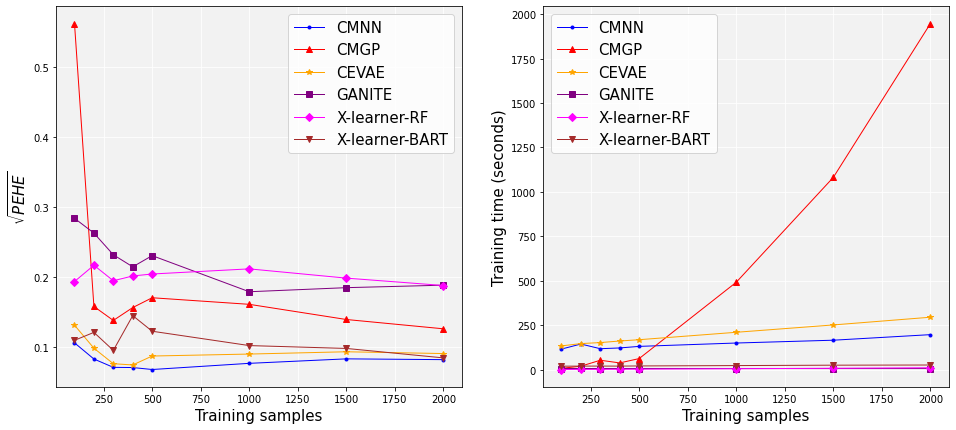

In [11]:
with open('./results/acic_challenge_results.pkl', 'rb') as fp:
    res = pkl.load(fp)

fig, axs = plt.subplots(1,2,figsize=(16,7))
training_samples = list(res.keys())
model_names = ['cmnn', 'cmgp', 'cevae', 'ganite', 'x_learner_rf', 'x_learner_bart']
colors = ['blue', 'red', 'orange', 'purple', 'magenta', 'brown']
markers = ['.', '^', '*', 's', 'D', 'v']
labels = ['CMNN', 'CMGP', 'CEVAE', 'GANITE', 'X-learner-RF', 'X-learner-BART']
for i in range(len(model_names)):
    sqrt_pehe = [x['sqrt_pehe_'+model_names[i]] for x in list(res.values())]
    train_time = [x['train_time_'+model_names[i]] for x in list(res.values())]
    axs[0].plot(training_samples, sqrt_pehe, lw=1, color=colors[i], marker=markers[i], label=labels[i])
    axs[1].plot(training_samples, train_time, lw=1, color=colors[i], marker=markers[i], label=labels[i])
axs[0].set_xlabel('Training samples', fontsize=15)
axs[0].set_ylabel('$\sqrt{PEHE}$', fontsize=15)
axs[0].set_facecolor('#F2F2F2')
axs[0].grid(color='white')
axs[0].legend(fontsize=15)
axs[1].set_xlabel('Training samples', fontsize=15)
axs[1].set_ylabel('Training time (seconds)', fontsize=15)
axs[1].set_facecolor('#F2F2F2')
axs[1].grid(color='white')
axs[1].legend(fontsize=15)

if not os.path.exists('./Figures'):
    os.makedirs('./Figures')
plt.savefig('./Figures/acic_challenge_results.pdf', dpi=300, bbox_inches='tight')